In [86]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pingouin import ancova
import seaborn as sns
import matplotlib.pyplot as plt

# Import Data

In [87]:
# Qualtrics data, extra rows contain headers
df_headers = pd.read_csv('/'.join(['data','AI+Learning+Research.csv']), header=[0,1,2])
# Import jaccard_analysis for ANCOVA
df_values = pd.read_csv('/'.join(['output','jaccard_analysis_extended.csv']), header=[0], parse_dates=['StartDate', 'EndDate', 'RecordedDate'])

df_headers.head(0).transpose()

,,
StartDate,Start Date,"{""ImportId"":""startDate"",""timeZone"":""America/New_York""}"
EndDate,End Date,"{""ImportId"":""endDate"",""timeZone"":""America/New_York""}"
Status,Response Type,"{""ImportId"":""status""}"
IPAddress,IP Address,"{""ImportId"":""ipAddress""}"
Progress,Progress,"{""ImportId"":""progress""}"
Duration (in seconds),Duration (in seconds),"{""ImportId"":""duration""}"
Finished,Finished,"{""ImportId"":""finished""}"
RecordedDate,Recorded Date,"{""ImportId"":""recordedDate"",""timeZone"":""America/New_York""}"
ResponseId,Response ID,"{""ImportId"":""_recordId""}"
RecipientLastName,Recipient Last Name,"{""ImportId"":""recipientLastName""}"


# ANCOVA

In [88]:
# Including a covariate of Jaccard similarity for the initial response with ChatGPT
ancova(data=df_values, dv='jaccard_gpt', covar='jaccard_gpt_initial', between='condition_experiment')

,Source,SS,DF,F,p-unc,np2
0,condition_experiment,0.157480,1,4.311774,0.038681,0.013850
1,jaccard_gpt_initial,0.404343,1,11.070830,0.000984,0.034806
2,Residual,11.212657,307,NaN,NaN,NaN


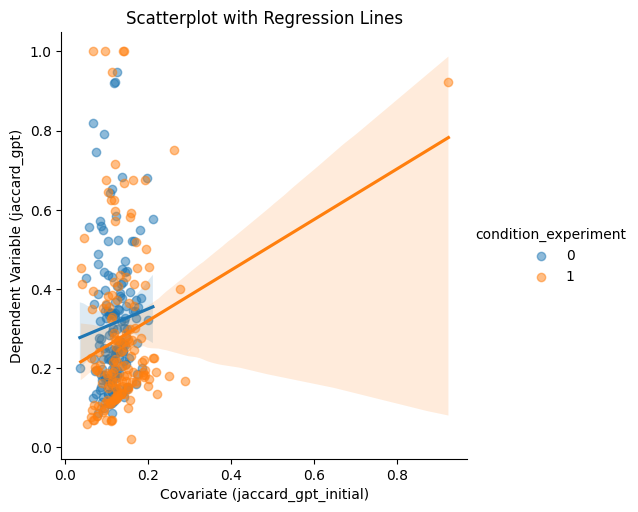

In [95]:
# Create scatterplot with separate regression lines
sns.lmplot(x='jaccard_gpt_initial', y='jaccard_gpt', hue='condition_experiment', data=df_values, scatter_kws={'alpha':0.5})
plt.title('Scatterplot with Regression Lines')
plt.xlabel('Covariate (jaccard_gpt_initial)')
plt.ylabel('Dependent Variable (jaccard_gpt)')
plt.show()

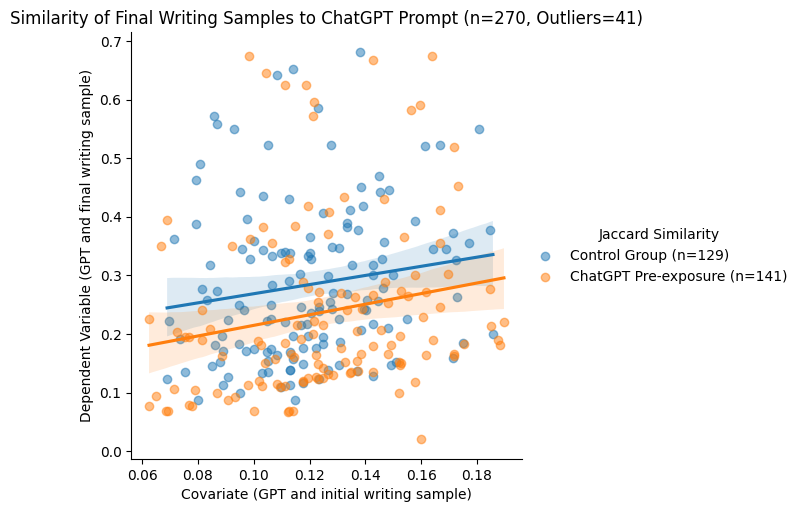

In [99]:
# Calculate the interquartile range (IQR) for the covariate variable
Q1 = df_values['jaccard_gpt_initial'].quantile(0.25)
Q3 = df_values['jaccard_gpt_initial'].quantile(0.75)
IQR = Q3 - Q1
# Define the upper and lower bounds for outliers removal for the covariate variable
lower_bound_cov = Q1 - 1.0 * IQR
upper_bound_cov = Q3 + 1.0 * IQR

# Calculate the interquartile range (IQR) for the dependent variable
Q1_dep = df_values['jaccard_gpt'].quantile(0.25)
Q3_dep = df_values['jaccard_gpt'].quantile(0.75)
IQR_dep = Q3_dep - Q1_dep
# Define the upper and lower bounds for outliers removal for the dependent variable
lower_bound_dep = Q1_dep - 1.5 * IQR_dep
upper_bound_dep = Q3_dep + 1.5 * IQR_dep

# Remove outliers for both variables
df_filtered = df_values[
    (df_values['jaccard_gpt_initial'] >= lower_bound_cov) & (df_values['jaccard_gpt_initial'] <= upper_bound_cov) &
    (df_values['jaccard_gpt'] >= lower_bound_dep) & (df_values['jaccard_gpt'] <= upper_bound_dep)
].copy()

#df_filtered.rename(columns={'jaccard_gpt_initial': 'Similarity of GPT and initial writing sample'}, inplace=True)
#df_filtered.rename(columns={'jaccard_gpt': 'Similarity of GPT and final writing sample'}, inplace=True)
df_filtered['condition_experiment'] = df_filtered['condition_experiment'].astype(str)
len_0 = len(df_filtered[df_filtered['condition_experiment'] == '1'])
len_1 = len(df_filtered[df_filtered['condition_experiment'] == '0'])
df_filtered.loc[df_filtered['condition_experiment'] == '0', 'condition_experiment'] = f'Control Group (n={len_0})'
df_filtered.loc[df_filtered['condition_experiment'] == '1', 'condition_experiment'] = f'ChatGPT Pre-exposure (n={len_1})'
df_filtered.rename(columns={'condition_experiment': 'Jaccard Similarity'}, inplace=True)

# Now create the plot with the filtered DataFrame
sns.lmplot(x='jaccard_gpt_initial', y='jaccard_gpt', hue='Jaccard Similarity', data=df_filtered, scatter_kws={'alpha':0.5})
plt.title(f'Similarity of Final Writing Samples to ChatGPT Prompt (n={len(df_filtered)}, Outliers={len(df_values)-len(df_filtered)})')
plt.xlabel('Covariate (GPT and initial writing sample)')
plt.ylabel('Dependent Variable (GPT and final writing sample)')
plt.show()

In [49]:
df_values.loc[df_values['condition_experiment'] == 0]['condition_experiment']


0      0
3      0
4      0
6      0
7      0
      ..
300    0
304    0
305    0
307    0
309    0
Name: condition_experiment, Length: 153, dtype: int64

In [5]:
ancova(data=df_values, dv='jaccard_gpt', covar='jaccard_similarity', between='condition_experiment')

,Source,SS,DF,F,p-unc,np2
0,condition_experiment,0.044969,1,1.356270,2.450891e-01,0.004398
1,jaccard_similarity,1.437883,1,43.366228,1.967165e-10,0.123774
2,Residual,10.179118,307,NaN,NaN,NaN
